In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox


In [2]:
all_weekly = pd.read_csv('./all_orders_weekly.csv', sep=';', index_col='date', parse_dates=True, dayfirst=True)
all_monthly = pd.read_csv('./all_orders_monthly.csv', sep=';', index_col='date', parse_dates=True, dayfirst=True)

In [3]:
all_monthly.index.freq = 'MS'
all_weekly.index.freq = 'W-SAT'

In [4]:
data = all_monthly

In [5]:
#definicao de periodos para teste
test_periods = 12
chart_train_period = data.shape[0] - test_periods

In [6]:
data.describe()

,Sales
count,43.000000
mean,901.883721
std,391.931858
min,252.000000
25%,638.500000
50%,861.000000
75%,1227.000000
max,1841.000000


In [7]:
data.head()

,Sales
date,
2020-09-01,252
2020-10-01,287
2020-11-01,312
2020-12-01,892
2021-01-01,1398


# Funções

In [8]:
def vendas(df, y, title, xlabel, ylabel):
    ax = df.plot.line(y=y, figsize = (12,5), label = ylabel)
    ax.set_ylim(bottom=0)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

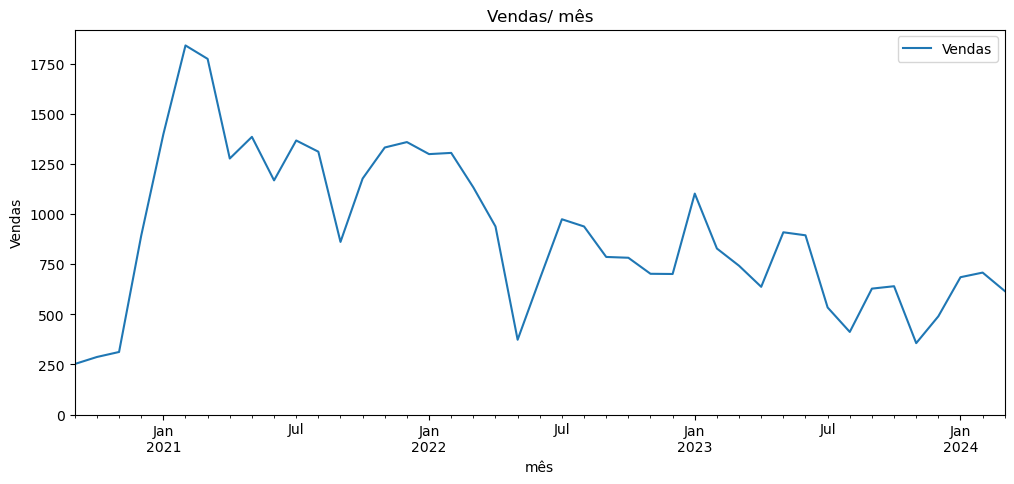

In [9]:
vendas(data, 'Sales', 'Vendas/ mês', 'mês', 'Vendas')

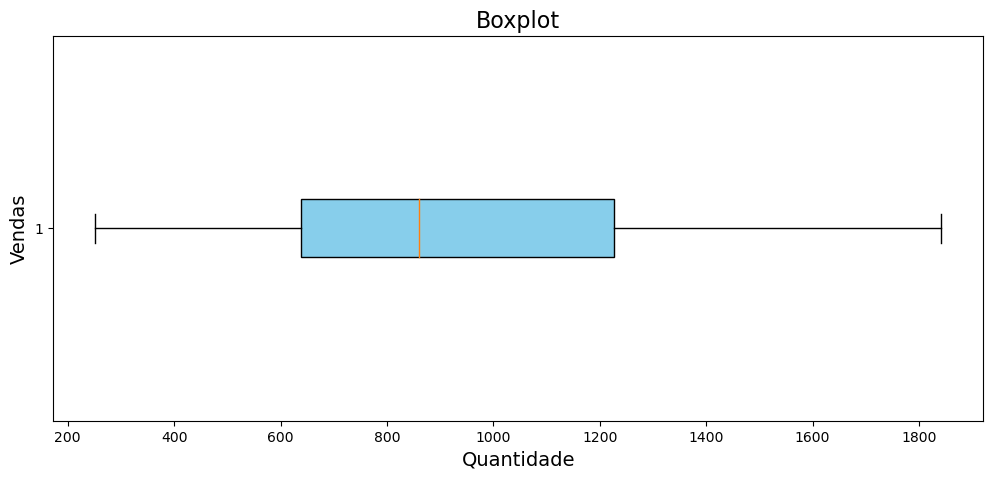

In [10]:
# Ajustando tamanho da figura
plt.figure(figsize=(12, 5))

# Ajuste de cor e direção do gráfico
plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))

# Legendas
plt.title('Boxplot', fontsize=16)
plt.xlabel('Quantidade', fontsize=14)
plt.ylabel('Vendas', fontsize=14)


plt.show()

## Erro, Tendência e Sazonalidade

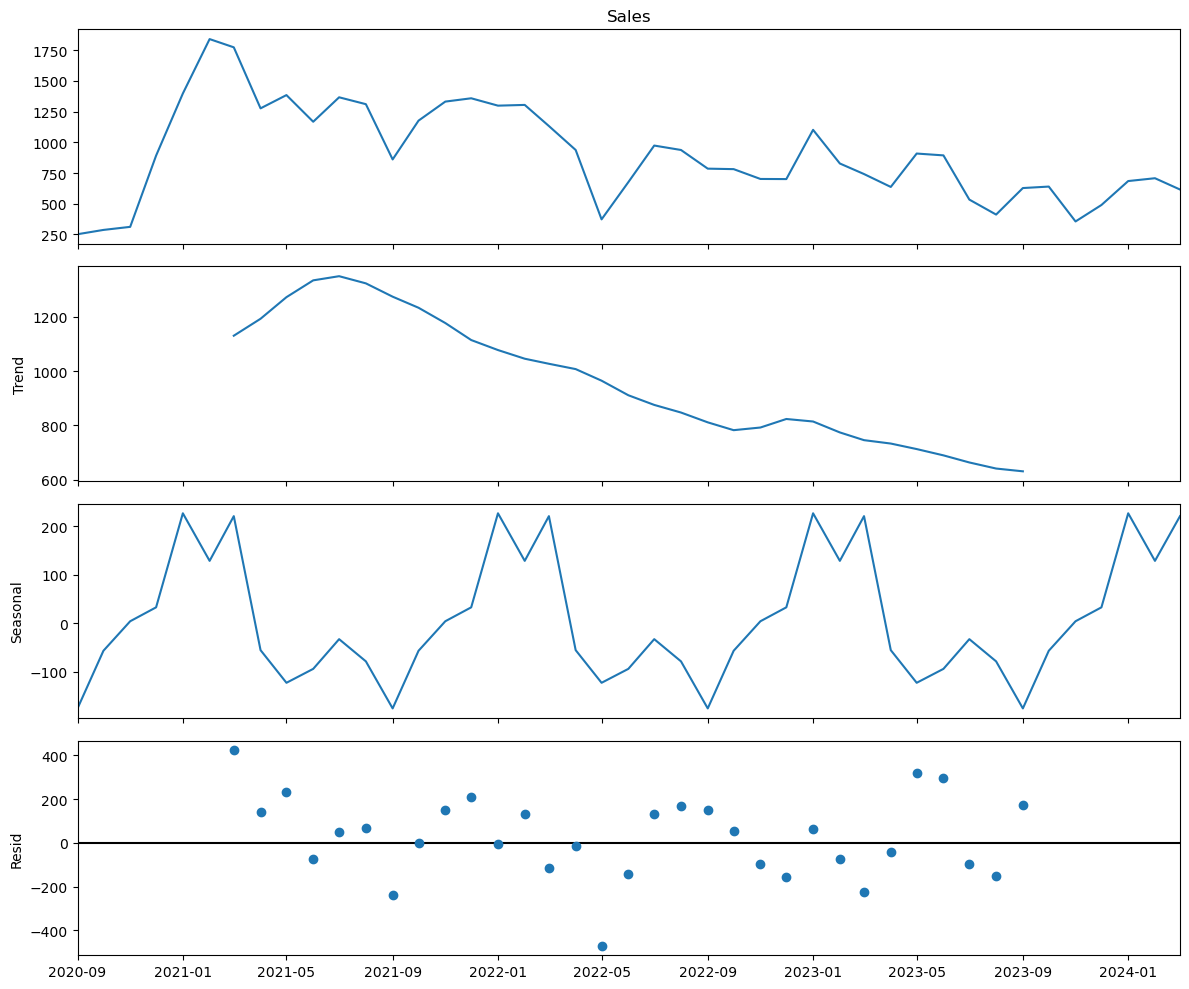

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,10

seasonalDecompose = seasonal_decompose(data['Sales'], model = 'add')
seasonalDecompose.plot();

In [12]:
train = data[:- test_periods]
test = data[-test_periods:]

In [13]:
def theil_ineq(predictions, test):  
    num = []
    den = []
    for i in range(len(predictions) - 1):
        num_n = ((predictions[(i + 1)] - test['Sales'][(i +1)]) / test['Sales'][i])**2
        num.append(num_n)

        den_n = ((test['Sales'][(i +1)] - test['Sales'][i]) / test['Sales'][i])**2
        den.append(den_n)

    numerador = np.sum(num)
    denominador = np.sum(den)
    div = numerador / denominador
    tic = np.sqrt(div)
    
    return tic


In [14]:
#inicialização da lista de resultados
result= []

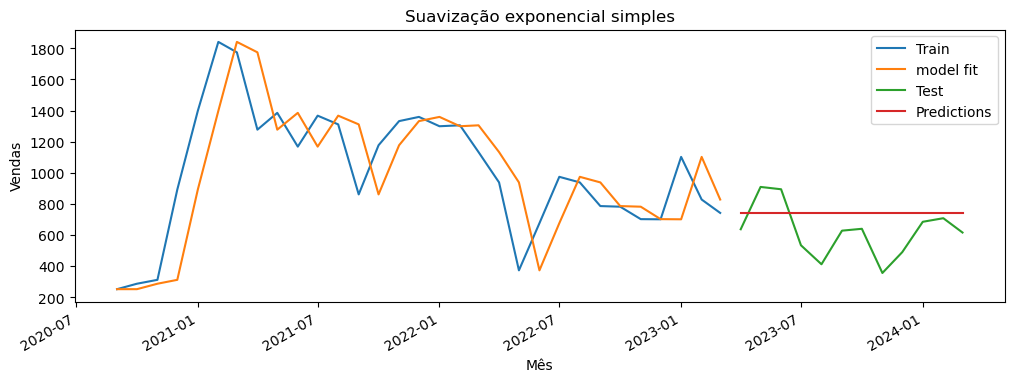

Mean Squared Error: 39196.91696461541
Mean Absolute Error: 169.41666752099994
Mean Absolute Percentage Error: 33.202489025088866
Root Mean Squared Error: 197.9821127390437
Theil Inequality Coefficient : 1.141968510422941
ljungbox p-value:  44.65638681194453
AIC:  351.85971560539457
                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Sales   No. Observations:                   31
Model:             SimpleExpSmoothing   SSE                        2315806.009
Optimized:                       True   AIC                            351.860
Trend:                           None   BIC                            354.728
Seasonal:                        None   AICC                           353.398
Seasonal Periods:                None   Date:                 Tue, 09 Apr 2024
Box-Cox:                        False   Time:                         13:16:40
Box-Cox Coeff.:                  None                                         
      

In [15]:
model = SimpleExpSmoothing(train)

model_fit = model.fit()

predictions = model_fit.forecast(steps=test_periods)


plt.figure(figsize=(12, 4))
plt.plot(train[-chart_train_period:], label='Train')
model_fit.fittedvalues.plot(label='model fit')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.title('Suavização exponencial simples')
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.legend()
plt.show()

mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions) * 100
rmse = np.sqrt(mse)
tic = theil_ineq(predictions, test)
aic = model_fit.aic
ljungbox = acorr_ljungbox(model_fit.resid, lags=1)['lb_pvalue'].values[0] * 100

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Theil Inequality Coefficient :", tic)
print('ljungbox p-value: ', ljungbox)
print('AIC: ', aic)

print(model_fit.summary())

card = {'model': 'SES',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Theil Inequality Coefficient " : tic,
       'AIC': aic,
       'ljungbox p-value': ljungbox}

result.append(card)

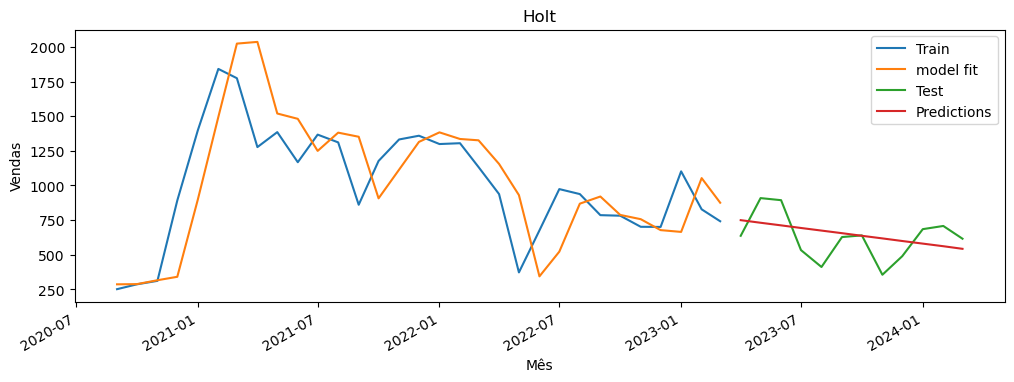

Mean Squared Error: 24248.57216595061
Mean Absolute Error: 135.05408692370725
Mean Absolute Percentage Error: 24.989715316551163
Root Mean Squared Error: 155.7195304576488
Theil Inequality Coefficient : 0.8003133752392924
                              Holt Model Results                              
Dep. Variable:                  Sales   No. Observations:                   31
Model:                           Holt   SSE                        2812927.331
Optimized:                      False   AIC                            361.888
Trend:                       Additive   BIC                            367.624
Seasonal:                        None   AICC                           365.388
Seasonal Periods:                None   Date:                 Tue, 09 Apr 2024
Box-Cox:                        False   Time:                         13:16:40
Box-Cox Coeff.:                  None                                         
                       coeff                 code              opti

In [16]:
model = Holt(train)

model_fit = model.fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)

predictions = model_fit.forecast(test_periods)

plt.figure(figsize=(12, 4))
plt.plot(train[-chart_train_period:], label='Train')
model_fit.fittedvalues.plot(label='model fit')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.title('Holt')
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.legend()
plt.show()

mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions) * 100
rmse = np.sqrt(mse)
tic = theil_ineq(predictions, test)
aic = model_fit.aic
ljungbox = acorr_ljungbox(model_fit.resid, lags=1)['lb_pvalue'].values[0] * 100

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Theil Inequality Coefficient :", tic)

print(model_fit.summary())

card = {'model': 'HOLT',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Theil Inequality Coefficient " : tic,
       'AIC': aic,
       'ljungbox p-value': ljungbox}

result.append(card)

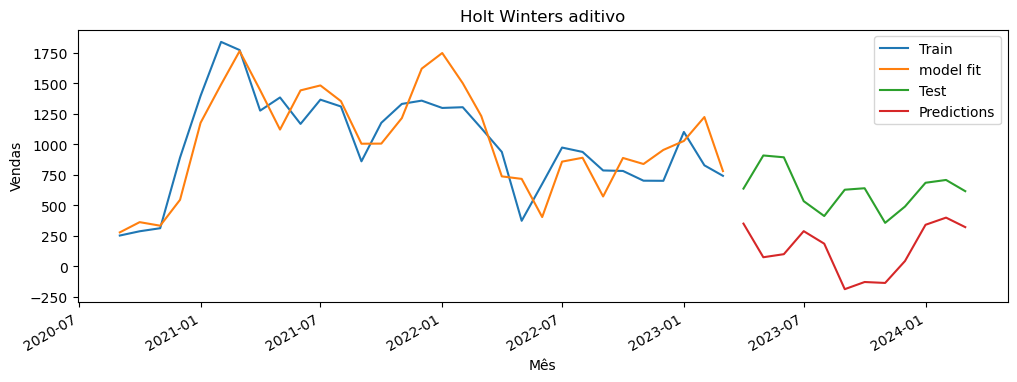

Mean Squared Error: 293896.080441517
Mean Absolute Error: 488.7596800417845
Mean Absolute Percentage Error: 79.07368216553193
Root Mean Squared Error: 542.1218317329759
Theil Inequality Coefficient : 3.072798335619672
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   31
Model:             ExponentialSmoothing   SSE                        1423268.669
Optimized:                         True   AIC                            364.769
Trend:                         Additive   BIC                            387.713
Seasonal:                      Additive   AICC                           421.769
Seasonal Periods:                    12   Date:                 Tue, 09 Apr 2024
Box-Cox:                          False   Time:                         13:16:40
Box-Cox Coeff.:                    None                                         
                          coeff                 code 

In [17]:
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)

model_fit = model.fit()

predictions = model_fit.forecast(steps=test_periods)

plt.figure(figsize=(12, 4))
plt.plot(train[-chart_train_period:], label='Train')
model_fit.fittedvalues.plot(label='model fit')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.title('Holt Winters aditivo')
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.legend()
plt.show()

mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions) * 100
rmse = np.sqrt(mse)
tic = theil_ineq(predictions, test)
aic = model_fit.aic
ljungbox = acorr_ljungbox(model_fit.resid, lags=1)['lb_pvalue'].values[0] * 100

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Theil Inequality Coefficient :", tic)

print(model_fit.summary())

card = {'model': 'HW-Add',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Theil Inequality Coefficient " : tic,
       'AIC': aic,
       'ljungbox p-value': ljungbox}

result.append(card)

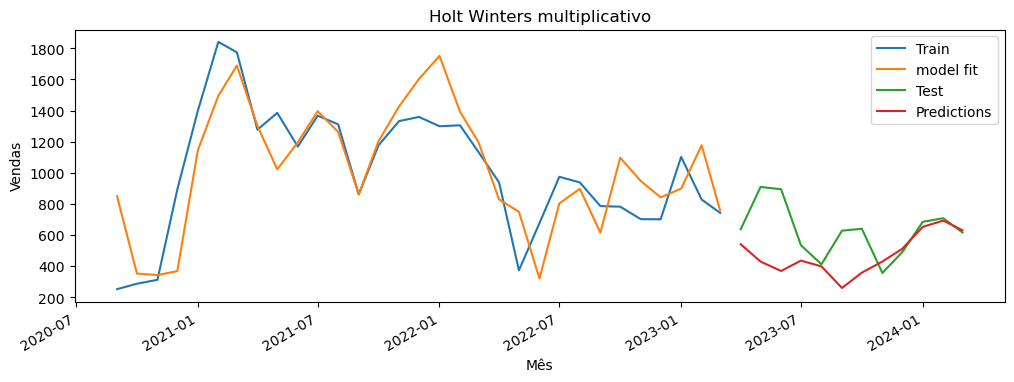

Mean Squared Error: 62297.96304771252
Mean Absolute Error: 168.39925019748452
Mean Absolute Percentage Error: 23.78272637449528
Root Mean Squared Error: 249.59559901511187
Theil Inequality Coefficient : 1.2773393985722752
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   31
Model:             ExponentialSmoothing   SSE                        1932543.156
Optimized:                         True   AIC                            374.251
Trend:                         Additive   BIC                            397.195
Seasonal:                Multiplicative   AICC                           431.251
Seasonal Periods:                    12   Date:                 Tue, 09 Apr 2024
Box-Cox:                           True   Time:                         14:06:34
Box-Cox Coeff.:                 0.98441                                         
                          coeff                 c

In [29]:
model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12, use_boxcox=True)

model_fit = model.fit()

predictions = model_fit.forecast(steps=test_periods)

plt.figure(figsize=(12, 4))
plt.plot(train[-chart_train_period:], label='Train')
model_fit.fittedvalues.plot(label='model fit')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.title('Holt Winters multiplicativo')
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.legend()
plt.show()

mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions) * 100
rmse = np.sqrt(mse)
tic = theil_ineq(predictions, test)
aic = model_fit.aic
ljungbox = acorr_ljungbox(model_fit.resid, lags=1)['lb_pvalue'].values[0] * 100

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Theil Inequality Coefficient :", tic)

print(model_fit.summary())

card = {'model': 'HW-Mul',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Theil Inequality Coefficient " : tic,
        'AIC': aic,
       'ljungbox p-value': ljungbox}

result.append(card)

In [19]:
error = ['add', 'mul']
trend = ['add', 'mul', None]
seasonality = ['add', 'mul', None]
damped = [False, True]

iter_results = []

best_model = None
best_criteria = float('inf')  # Initialize with a very large value

# Iterate over all combinations
for err, trnd, seas, dmpd in product(error, trend, seasonality, damped):
    try:
        # Fit ETS model
        ets_model = ETSModel(train['Sales'], trend=trnd, seasonal=seas, seasonal_periods=12, error=err, damped_trend=dmpd)
        ets_result = ets_model.fit()
        predictions = ets_result.forecast(steps=test_periods)
        mape = mean_absolute_percentage_error(test, predictions)
        aic = ets_result.aic
        iter_settings = {'err' : err, 
                         'trend' : trnd,
                         'seasonality' : seas,  
                         'Dumped Trend' : dmpd,
                         'MAPE' : mape,
                         'AIC': aic}
        criterion = aic
        # Update best model if current model is better
        if criterion < best_criteria:
            best_criteria = criterion
            best_model = (err, trnd, seas, dmpd)
        iter_results.append(iter_settings)
    except:
        continue


print("Best ETS model:", best_model)
print("Best criterion:", best_criteria)

Best ETS model: ('mul', None, 'add', False)
Best criterion: 440.9242751171647


In [20]:
pd.DataFrame(iter_results).to_excel('ets_iter_results.xlsx')

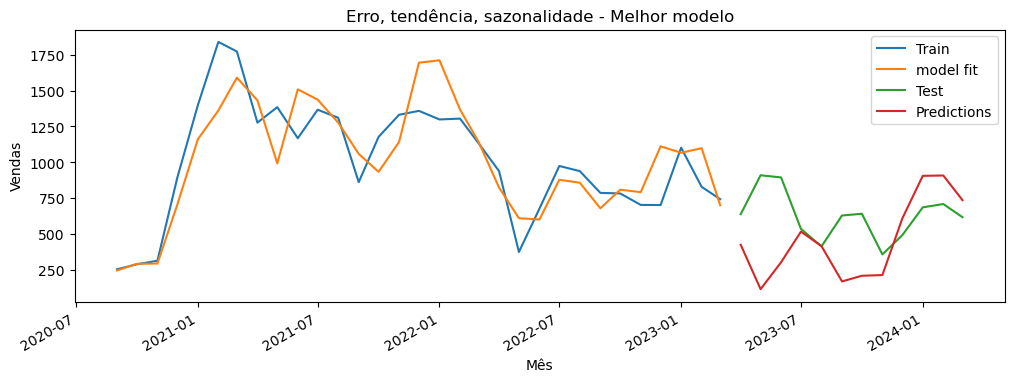

Mean Squared Error: 130581.32752305182
Mean Absolute Error: 276.3054207612349
Mean Absolute Percentage Error: 39.6897232772784
Root Mean Squared Error: 361.36038455128397
Theil Inequality Coefficient : 1.8775735873331603
                                 ETS Results                                  
Dep. Variable:                  Sales   No. Observations:                   31
Model:                       ETS(MNA)   Log Likelihood                -204.462
Date:                Tue, 09 Apr 2024   AIC                            440.924
Time:                        13:16:43   BIC                            463.868
Sample:                    09-01-2020   HQIC                           448.403
                         - 03-01-2023   Scale                            0.037
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [21]:
model = ETSModel(train['Sales'], error=best_model[0], seasonal=best_model[2], trend=best_model[1], 
                 damped_trend=best_model[3], seasonal_periods=12)




fit = model.fit()


predictions = fit.forecast(steps=test_periods)

plt.figure(figsize=(12, 4))
plt.plot(train[-chart_train_period:], label='Train')
fit.fittedvalues.plot(label='model fit')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')

plt.title('Erro, tendência, sazonalidade - Melhor modelo')
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.legend()
plt.show()


mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions) * 100
rmse = np.sqrt(mse)
tic = theil_ineq(predictions, test)
aic = fit.aic
ljungbox = acorr_ljungbox(fit.resid, lags=1)['lb_pvalue'].values[0] * 100

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Theil Inequality Coefficient :", tic)

print(fit.summary())


card = {'model': 'ETS',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Theil Inequality Coefficient " : tic,
       'AIC': aic,
       'ljungbox p-value': ljungbox}

result.append(card)

In [22]:
pd.DataFrame(result).T

,0,1,2,3,4
model,SES,HOLT,HW-Add,HW-Mul,ETS
Mean Squared Error,39196.916965,24248.572166,293896.080442,62297.963048,130581.327523
Mean Absolute Error,169.416668,135.054087,488.75968,168.39925,276.305421
Mean Absolute Percentage Error,33.202489,24.989715,79.073682,23.782726,39.689723
Root Mean Squared Error,197.982113,155.71953,542.121832,249.595599,361.360385
Theil Inequality Coefficient,1.141969,0.800313,3.072798,1.277339,1.877574
AIC,351.859716,361.888221,364.768863,374.251166,440.924275
ljungbox p-value,44.656387,13.860457,64.51193,37.612064,99.771223
